In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_train=pl.read_parquet('data/data_full_train.parquet')
data_val=pl.read_parquet('data/data_full_val.parquet')

In [4]:
data_train=dmf.clean_accepted_rejected(data_train)
data_val=dmf.clean_accepted_rejected(data_val)

data_train=feats.month_cyclic_features(data_train,"Application Date")
data_val=feats.month_cyclic_features(data_val,"Application Date")

data_train=feats.title_text_features(data_train)
data_val=feats.title_text_features(data_val)

In [5]:
data_train=feats.title_text_features(data_train)
data_train=feats.title_text_features(data_train)

In [6]:
X_train = data_train.drop(columns=['Application Date','month','Policy Code'])
X_val= data_val.drop(columns=['Application Date','month','Policy Code'])
y_train = data_train['Policy Code']
y_val= data_val['Policy Code']

In [7]:
X_mini_train, discard1, y_mini_train, discard2 = train_test_split(
    X_train, y_train, stratify=y_train,train_size=3000000,test_size=2
)

X_mini_val, discard1, y_mini_val, discard2 = train_test_split(
    X_val, y_val, stratify=y_val,train_size=900000,test_size=2
)

## Pipelines

### LightGBM

In [8]:
X_mini_train.null_count()

Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,title,month_sin,month_cos,title_contains_numbers,title_length,title_starts_with_lowercase
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
182,171788,46,3,115291,5961,0,0,5961,5961,5961


#### Imputers

In [15]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=51,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)


imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("title_imp",title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step("zip_code_imp", zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step("state_imp",state_imputer, "State"),
        tr.PolarsColumnTransformer.Step("len_imp",emp_length_imputer, "Employment Length"),
    ]
)

#### Encoders and selection

In [16]:
state_encoder = tr.TargetMeanOrderedLabeler()
zip_encoder = tr.TargetMeanOrderedLabeler()
title_encoder = tr.TargetMeanOrderedLabeler()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder = tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("state", state_encoder, "State"),
        tr.PolarsColumnTransformer.Step("zip_code",zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step("title", title_encoder, "title"),
        tr.PolarsColumnTransformer.Step("emp_length", employment_encoder, "Employment Length"),
    ]
)
null_imp = tr.PolarsNullImputer(fill_value=-9)

model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    force_col_wise=True,
    verbose=-1,
    num_threads=1,
    random_state=1,
)

boruta = tr.BorutaFeatureSelectorPolars(model_lgbm, random_state=1, perc=100)

preprocess_lgbm = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("null_imputer", null_imp),
        ("boruta", boruta),
    ]
)

In [17]:
full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1, 100),
    "preprocess__boruta__apply": tune.choice([True, False]),
    "model__num_leaves": tune.randint(10, 150),
    "model__n_estimators": tune.randint(1, 250),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 10),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 200),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models = tunes.Models()
models.add_model("lgbm_yn", full_pipeline, search_space_lgbm, metric_threshold=0.55)

### Tree

In [18]:
imputer_tree = copy.deepcopy(imputer)
encoder_tree = copy.deepcopy(encoder)
null_imp_tree = copy.deepcopy(null_imp)
preprocess_tree = Pipeline(
    [
        ("imputer", imputer_tree),
        ("encoder", encoder_tree),
        ("null_imputer", null_imp_tree),
    ]
)

model_tree = DecisionTreeClassifier()

full_pipeline_tree = Pipeline(
    [
        ("preprocess", preprocess_tree),
        ("model", model_tree),
    ]
)

search_space_tree = {
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "tree_yn", full_pipeline_tree, search_space_tree, metric_threshold=0.42
)

### Logreg

In [19]:
imputer_logreg = copy.deepcopy(imputer)
encoder_logreg = copy.deepcopy(encoder)
null_imp_logreg = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(
            "dti_imp", tr.PolarsNullImputer(10000), "Debt-To-Income Ratio"
        ),
        tr.PolarsColumnTransformer.Step(
            "requested_imp", tr.PolarsNullImputer(0), "Amount Requested"
        ),
        tr.PolarsColumnTransformer.Step(
            "contains_num_imp", tr.PolarsNullImputer(0), "title_contains_numbers"
        ),
        tr.PolarsColumnTransformer.Step(
            "lowercase_imp", tr.PolarsNullImputer(0), "title_starts_with_lowercase"
        ),
        tr.PolarsColumnTransformer.Step(
            "title_len_imp", tr.PolarsNullImputer(0), "title_length"
        ),
    ]
)
preprocess_logreg = Pipeline(
    [
        ("imputer", imputer_logreg),
        ("encoder", encoder_logreg),
        ("null_imputer", null_imp_logreg),
    ]
)

model_logreg = LogisticRegression(class_weight="balanced", max_iter=10000)

full_pipeline_logreg = Pipeline(
    [
        ("preprocess", preprocess_logreg),
        ("model", model_logreg),
    ]
)

search_space_logreg = {
    "model__penalty": tune.choice(
        [
            "l1",
            "l2",
        ]
    ),
    "model__C": tune.loguniform(0.001, 10.0),
    "model__solver": tune.choice(["saga"]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "logreg_yn",
    full_pipeline_logreg,
    search_space_logreg,
    metric_threshold=0.42,
    override_n=64,
)

In [20]:
models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=96,sample_size=300000)

In [ ]:
joblib.dump(models, 'models_yn.joblib')

['models_yn.joblib']

In [ ]:
models.models['lgbm_yn'].pipeline.fit(X_mini_train.sample(1000000,seed=1),y_mini_train.sample(1000000,seed=1))
models.models['logreg_yn'].pipeline.fit(X_mini_train.sample(1000000,seed=1),y_mini_train.sample(1000000,seed=1))
models.models['tree_yn'].pipeline.fit(X_mini_train.sample(1000000,seed=1),y_mini_train.sample(1000000,seed=1))


The max_iter was reached which means the coef_ did not converge


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=[<functions.transformers.PolarsColumnTransformer.Step object at 0x7fc5d80a98e0>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7fc2c149d280>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7fc2c149d460>,
                                                                 <functions.transformers.PolarsColu...
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7fc2c149dd30>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7fc2c149d880>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7fc2c149d940>])),
                                 ('null_imputer',
                                  PolarsNullImputer(fill_value=-9))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6))])

In [ ]:
models.models['lgbm_yn'].pipeline

{'preprocess__boruta__perc': 61,
 'preprocess__boruta__apply': False,
 'model__num_leaves': 176,
 'model__n_estimators': 77,
 'model__learning_rate': 0.023644220778324905,
 'model__colsample_bytree': 0.4059053890071986,
 'model__subsample': 0.6059095802897383,
 'model__reg_alpha': 0.007881035693860478,
 'model__reg_lambda': 0.1619651028629632,
 'model__boosting_type': 'gbdt'}

In [ ]:
models.models['tree_yn'].best_params

{'model__criterion': 'entropy',
 'model__splitter': 'best',
 'model__max_depth': 6,
 'model__max_features': None}

In [ ]:
preds_lgbm =models.models['lgbm_yn'].pipeline.predict(X_val)
preds_logreg =models.models['logreg_yn'].pipeline.predict(X_val)
preds_tree =models.models['tree_yn'].pipeline.predict(X_val)
# 

In [ ]:
print(classification_report(y_val,preds_lgbm))
print(classification_report(y_val,preds_logreg))
print(classification_report(y_val,preds_tree))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97   2849034
           1       0.50      0.87      0.64    148573

    accuracy                           0.95   2997607
   macro avg       0.75      0.91      0.81   2997607
weighted avg       0.97      0.95      0.96   2997607

              precision    recall  f1-score   support

           0       1.00      0.06      0.12   2849034
           1       0.05      1.00      0.10    148573

    accuracy                           0.11   2997607
   macro avg       0.53      0.53      0.11   2997607
weighted avg       0.95      0.11      0.12   2997607

              precision    recall  f1-score   support

           0       0.98      0.98      0.98   2849034
           1       0.61      0.71      0.66    148573

    accuracy                           0.96   2997607
   macro avg       0.80      0.84      0.82   2997607
weighted avg       0.97      0.96      0.96   2997607



 99%|===================| 9857/10000 [00:41<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


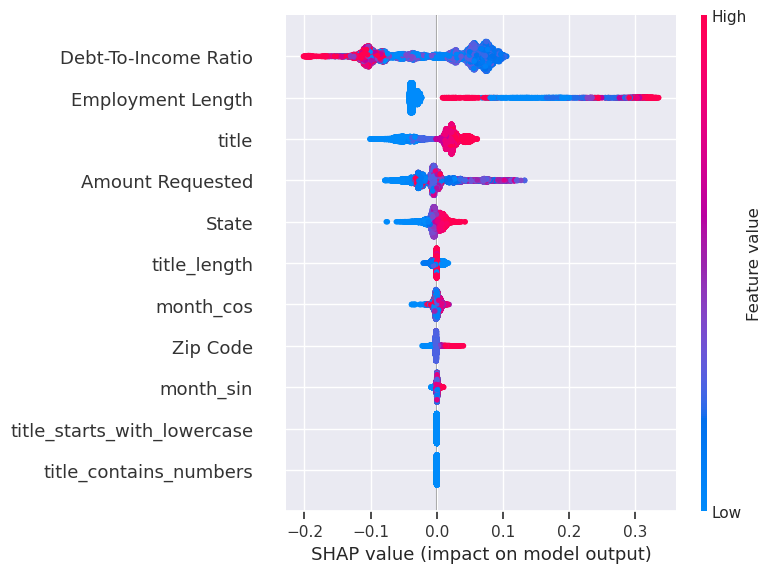

In [ ]:
names = full_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    full_pipeline["model"],
    data=full_pipeline["preprocess"]
    .transform((X_mini_val.sample(10000, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    full_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    full_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

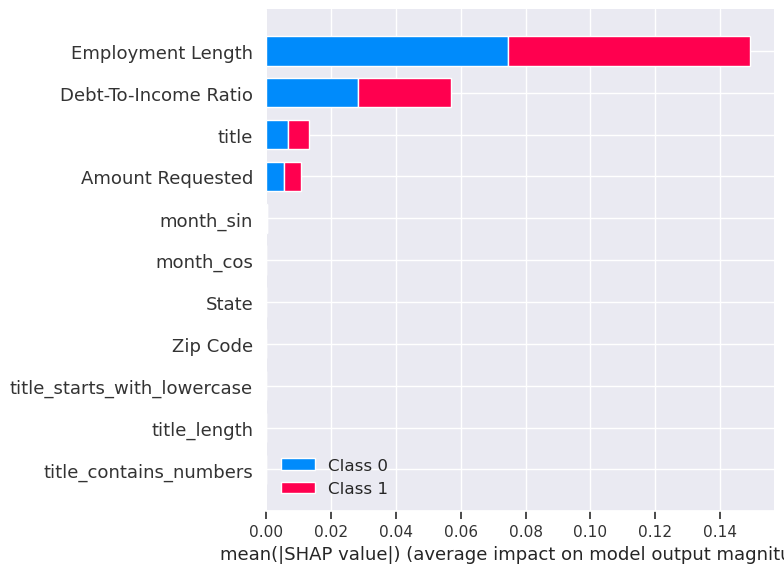

In [ ]:
names = models.models['tree_yn'].pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    models.models['tree_yn'].pipeline['model'],
    data=models.models['tree_yn'].pipeline["preprocess"]
    .transform((X_mini_val.sample(10000, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    models.models['tree_yn'].pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    models.models['tree_yn'].pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

In [ ]:
from sklearn.tree import export_graphviz

In [ ]:
export_graphviz(
        models.models['tree_yn'].pipeline['model'],
        out_file=("tree.dot"),
        feature_names=names,
        class_names=["0","1"],
        rounded=True,
        filled=True
    )

!dot -Tpng tree.dot -o tree.png


<img src="tree.png" alt="Alt text" width="1700.0" height="900.0" />